In [78]:
# Remove unwanted warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', catgeory=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader.data import DataReader
from ta import add_all_ta_features

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

### Initial Data Extraction

In [79]:
# Data Extraction
start_date = "2017-01-01"
end_date = "2022-06-01"
symbol = "^VIX"
df = yf.download(symbol, start_date, end_date, group_by="Ticker")
df.columns = df.columns.get_level_values(1)
df

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,14.070000,14.070000,12.850000,12.850000,0
2017-01-04,12.780000,12.800000,11.630000,11.850000,0
2017-01-05,11.960000,12.090000,11.400000,11.670000,0
2017-01-06,11.700000,11.740000,10.980000,11.320000,0
2017-01-09,11.710000,12.080000,11.460000,11.560000,0
...,...,...,...,...,...
2022-05-24,29.430000,31.070000,29.040001,29.450001,0
2022-05-25,29.330000,30.230000,28.160000,28.370001,0
2022-05-26,28.420000,28.459999,27.110001,27.500000,0


In [80]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
df.head()

/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


Price,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,...,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,0,-0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1000.0,12.850000,12.850000,12.850000,0.000000,0.000000,0.0,0.0,13.256667,14.476666,12.036668,18.405823,0.333333,0.0,0.0,12.85,14.07,13.460,9.494158,0.000000,0.0,0.0,0.000000,0.000000,0.000000,12.850000,...,0.000000,13.460,13.460,13.460,13.460,0.0,0.0,0.0,0.0,0.000000,20.470312,22.232963,4.0,4.0,0.0,10.94,14.070000,0.0,0.0,100.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-100.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.850000,-32.349937,0.000000,0.000000
2017-01-04,12.78,12.80,11.63,11.85,0,-0.0,0,0.0,-0.0,0.0,0.0,-0.0,0.0,50.0,1000.0,12.350000,13.350000,11.350000,16.194331,0.250000,0.0,0.0,12.675000,13.870000,11.480000,18.856011,0.154812,0.0,0.0,11.63,14.07,12.850,19.757081,0.090164,0.0,0.0,-0.079772,-0.015954,-0.063818,12.350000,...,-13.161491,12.850,12.850,12.850,12.850,0.0,0.0,0.0,0.0,-66.666667,20.470312,22.232963,4.0,8.0,-4.0,10.94,14.070000,0.0,0.0,0.000000,0.0,0.0,0.0,-100.000000,9.016406,9.016406,4.508203,-90.983594,0.0,0.0,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,12.098375,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,11.40,11.67,0,-0.0,0,0.0,-0.0,0.0,0.0,-0.0,0.0,50.0,1000.0,12.123334,13.161452,11.085215,17.125952,0.281656,0.0,0.0,12.356667,13.383333,11.330000,16.617210,0.165584,0.0,0.0,11.40,14.07,12.735,22.023646,0.101124,0.0,0.0,-0.155721,-0.043908,-0.111814,12.123334,...,-16.729720,12.735,12.735,12.735,12.735,0.0,0.0,0.0,0.0,-70.740755,20.470312,22.232963,4.0,12.0,-8.0,10.94,14.070000,0.0,1.0,0.000000,0.0,0.0,0.0,-100.000000,15.654975,10.112376,6.376261,-89.887624,0.0,0.0,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,11.825780,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,10.98,11.32,0,-0.0,0,0.0,-0.0,0.0,0.0,-0.0,0.0,50.0,1000.0,11.922500,13.059283,10.785717,19.069543,0.234998,0.0,0.0,12.104167,13.064167,11.144167,15.862307,0.091580,0.0,0.0,10.98,14.07,12.525,25.917384,0.110032,0.0,0.0,-0.241372,-0.083401,-0.157971,11.922500,...,-20.477094,12.525,12.525,12.525,12.525,0.0,0.0,0.0,0.0,-87.635601,20.470312,22.232963,4.0,16.0,-12.0,10.94,14.016600,0.0,0.0,0.000000,0.0,0.0,0.0,-100.000000,21.336782,11.003241,10.044008,-88.996759,0.0,0.0,-1.916831,-0.659566,-1.257265,0.0,0.0,0.0,11.503803,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,11.46,11.56,0,-0.0,0,0.0,-0.0,0.0,0.0,0.0,0.0,50.0,1000.0,11.850000,12.907318,10.792683,17.845024,0.362861,0.0,0.0,12.023333,12.915333,11.131333,14.837815,0.240284,0.0,0.0,10.98,14.07,12.525,26.075950,0.187703,0.0,0.0,-0.286580,-0.124037,-0.162544,11.850000,...,-19.435139,12.525,12.525,12.525,12.525,0.0,0.0,0.0,0.0,-41.346950,20.470312,22.232963,4.0,16.0,-12.0,10.94,13.895136,0.0,0.0,15.780578,0.0,0.0,0.0,-99.449116,23.010784,18.770254,13.29529

### Data Preprocessing - Stationarity

In [81]:
# Identify non-stationary columns
non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-pack

Non-Stationary Features Found: 29


/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/mahan-maalekian/anaconda3/envs/MLTRADE/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [82]:
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [83]:
# Find Nan Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [84]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

Price,Open,High,Low,Close,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,12.78,12.80,-0.094942,11.85,0.0,0.0,12.350000,0.038911,-0.116732,16.194331,0.250000,0.0,0.0,12.675000,13.870000,-0.046248,18.856011,0.154812,0.0,0.0,-0.094942,14.07,-0.045319,19.757081,0.090164,0.0,0.0,-0.079772,-0.015954,-0.063818,-0.038911,-0.038911,12.696154,-0.005765,0.006789,0.331305,-0.324516,-0.015199,1.993432,6.644809,-349.822348,-336.660858,-13.161491,12.850,-0.045319,-0.045319,-0.045319,0.0,0.0,0.0,0.0,-66.666667,20.470312,0.0,4.0,8.0,-4.0,0.0,14.070000,0.0,0.0,0.000000,0.0,0.0,0.0,-100.000000,9.016406,9.016406,4.508203,-90.983594,0.000000,0.0,-0.624394,-0.124879,-0.499515,-0.058492,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,-0.019776,11.67,0.0,0.0,12.123334,-0.014123,-0.023329,17.125952,0.281656,0.0,0.0,12.356667,13.383333,-0.013066,16.617210,0.165584,0.0,0.0,-0.019776,14.07,-0.008949,22.023646,0.101124,0.0,0.0,-0.155721,-0.043908,-0.111814,-0.018354,-0.018354,12.538284,-0.006412,0.063316,0.476734,-0.413418,-0.042641,2.918491,6.871475,-361.755438,-345.025718,-16.729720,12.735,-0.008949,-0.008949,-0.008949,0.0,0.0,0.0,0.0,-70.740755,20.470312,0.0,4.0,12.0,-8.0,0.0,14.070000,0.0,1.0,0.000000,0.0,0.0,0.0,-100.000000,15.654975,10.112376,6.376261,-89.887624,0.000000,0.0,-1.226732,-0.345249,-0.881483,-0.022532,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,-0.036842,11.32,0.0,0.0,11.922500,-0.007763,-0.027018,19.069543,0.234998,0.0,0.0,12.104167,13.064167,-0.016402,15.862307,0.091580,0.0,0.0,-0.036842,14.07,-0.016490,25.917384,0.110032,0.0,0.0,-0.241372,-0.083401,-0.157971,-0.016566,-0.016566,12.350856,-0.008018,0.096429,0.561555,-0.465126,-0.082371,3.809335,7.072309,-372.328510,-351.851416,-20.477094,12.525,-0.016490,-0.016490,-0.016490,0.0,0.0,0.0,0.0,-87.635601,20.470312,0.0,4.0,16.0,-12.0,0.0,14.016600,0.0,0.0,0.000000,0.0,0.0,0.0,-100.000000,21.336782,11.003241,10.044008,-88.996759,0.000000,0.0,-1.916831,-0.659566,-1.257265,-0.027227,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,0.043716,11.56,0.0,0.0,11.850000,-0.011637,0.000646,17.845024,0.362861,0.0,0.0,12.023333,12.915333,-0.001152,14.837815,0.240284,0.0,0.0,0.000000,14.07,0.000000,26.075950,0.187703,0.0,0.0,-0.286580,-0.124037,-0.162544,-0.006081,-0.006081,12.229186,-0.006072,0.203659,0.546225,-0.342566,-0.124884,4.659285,7.144809,-376.145339,-356.710201,-19.435139,12.525,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-41.346950,20.470312,0.0,4.0,16.0,-12.0,0.0,13.895136,0.0,0.0,15.780578,0.0,0.0,0.0,-99.449116,23.010784,18.770254,13.295290,-81.229746,0.000000,0.0,-2.289756,-0.985604,-1.304152,0.002666,2.120148,2.097985,-10.038910
2017-01-10,11.59,11.79,-0.013089,11.49,0.0,0.0,11.790000,-0.008950,-0.000415,16.994041,0.350269,0.0,0.0,11.941111,12.764444,-0.001218,13.789894,0.226046,0.

### Data Preprocessing - Scaling and Target Setting

In [85]:
# Set Target (for Supervised ML later on)
df_stationary["TARGET"] = -1

# the target is essentially the future
df_stationary.loc[df_stationary["Close"].shift(-1) > df_stationary["Close"], "TARGET"] = 1
df_stationary.dropna(inplace=True)

In [86]:
# Split Target from FeatureSet
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [87]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [88]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

### Unsupervised ML - PCA Dimensionality Reduction

In [89]:
# PCA
n_components = 7
pca = PCA(n_components)
pca_result = pca.fit(X_train) # this learns the principal components
X_train_pca = pca_result.transform(X_train) # it transforms the original training data into PCA feature space
X_test_pca = pca_result.transform(X_test)

In [90]:
# Calculate the variance explained by Principle Components
print("Variance of each component: ", pca.explained_variance_ratio_)
print("\n Total Variance Explained: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

# it has given me 7 features and given me 80% of the information I needeed

Variance of each component:  [0.3939972  0.18829361 0.08444089 0.04867725 0.03302358 0.02537191
 0.02411191]

 Total Variance Explained:  79.79


In [91]:
# Create columns
pca_cols = []
for i in range(n_components):
    pca_cols.append(f"PC_{i}")
pca_cols

['PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6']

In [92]:
# Create and View DataFrame
df_pca = pd.DataFrame(data=X_train_pca, columns=pca_cols)
df_pca

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,-7.427649,0.247881,-0.757230,0.080937,4.326508,0.689852,-2.594671
1,-4.618850,-0.409648,-2.623187,0.733646,0.947016,0.890268,-0.065930
2,-1.877478,4.576526,-1.052689,0.683416,0.809714,0.597380,-1.886219
3,2.179683,-4.698729,-0.617177,0.913215,-1.691764,-0.918329,0.157737
4,-4.807416,0.846610,2.429558,-0.787190,1.889836,0.960467,0.458243
...,...,...,...,...,...,...,...
403,11.237843,-4.612766,3.759052,4.325699,0.390459,2.795261,-0.689669
404,-3.521056,-0.195236,-0.403618,-0.028416,0.601223,0.494104,-0.422434
405,6.391089,1.461508,2.219769,-1.567459,-0.214170,-1.091867,-0.957907
406,-7.088745,3.608973,3.313906,-1.526077,2.320435,0.788370,-1.061802


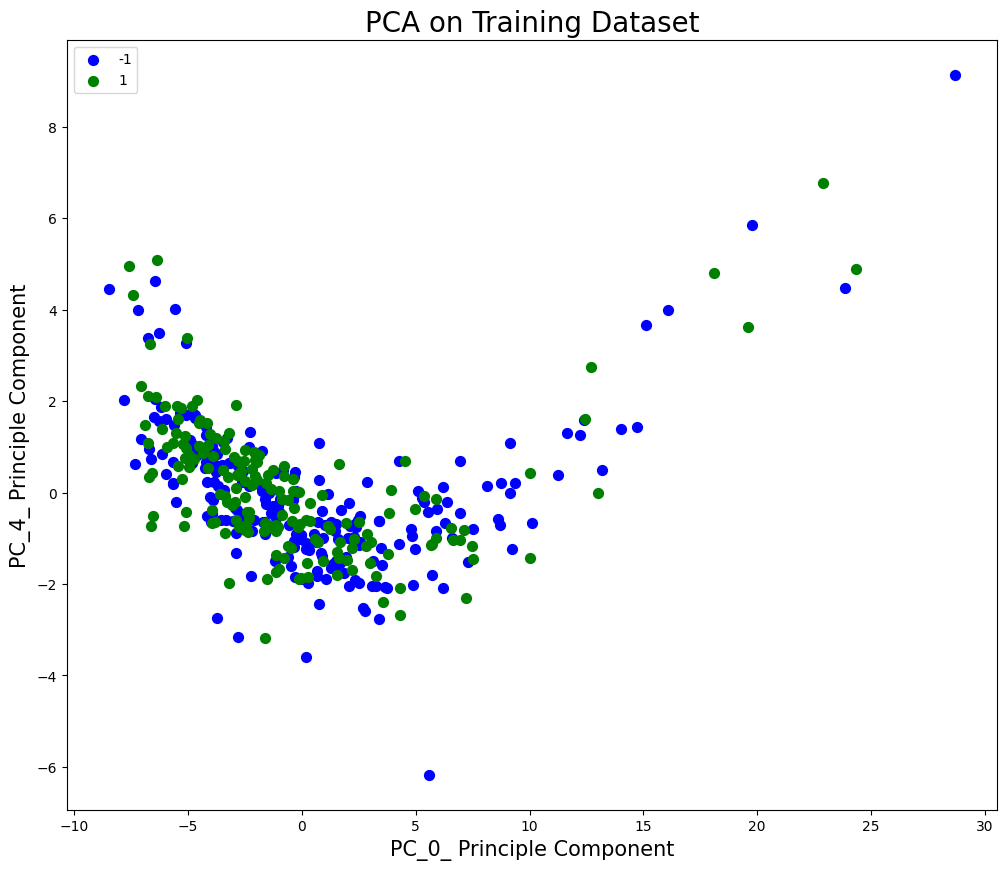

In [93]:
# Visualize Princeple Components with Scatter Plot
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
col_1 = "PC_0"
col_2 = "PC_4"
ax.set_xlabel(f"{col_1}_ Principle Component", fontsize=15)
ax.set_ylabel(f"{col_2}_ Principle Component", fontsize=15)
ax.set_title("PCA on Training Dataset", fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets, colors):
    indeice_to_keep = y_train == target
    indeice_to_keep = list(indeice_to_keep)
    ax.scatter(df_pca.loc[indeice_to_keep, col_1],
                df_pca.loc[indeice_to_keep, col_2],
                c = color,
    s = 50)
    ax.legend(targets)
    ax.grid

You can see if you can use the dimensions that you got in a K-means clustering or in a HMM for example

### Supervices ML - Random Forest Classification

In [94]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

# we can predict with a greater than 2% precision whether the price will go up or down tmrw

Test Accuracy: 0.5645330535152151
Test Precision: 0.5218978102189781


In [95]:
# this gives the model's confidence in whether the target will be 1 or -1, and you can use a threshold during
# backtesting to say that you only wanna execute if the confidence is above a certain threshold
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba


array([[0.46666867, 0.53333133],
       [0.64778934, 0.35221066],
       [0.50434566, 0.49565434],
       ...,
       [0.51114521, 0.48885479],
       [0.5458046 , 0.4541954 ],
       [0.50608642, 0.49391358]])

In [96]:
# Test for Overfitting
train_scores, test_scores = list(), list()
values = [i for i in range(1, 200)]
for i in values:
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)

    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)

    # Test Data
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)

What we are looking for here is we want to see whehter the model is overfitting. We can gage that by seeing if we add more estimators, does the train data keep going up and the test data start to go down in terms of accuracy. If that is the case, it means the model is overfitting to the train data and no longer accuractly predicts the test data.

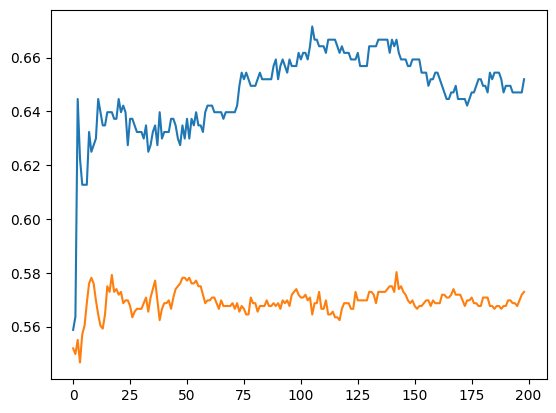

In [97]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()
